# Stable Diffusion Deep Dive

Stable Diffusion is a powerful text-to-image model. There are various websites and tools to make using it as easy as possible. It is also [integrated into the Huggingface diffusers library](https://huggingface.co/blog/stable_diffusion) where generating images can be as simple as:
```python
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16, use_auth_token=True).to("cuda")
image = pipe("An astronaught scuba diving").images[0]

```

In this notebook we're going to dig into the code behind these easy-to-use interfaces, to see what is going on under the hood. We'll begin by re-creating the functionality above as a scary chunk of code, and then one by one we'll inspect the different components and figure out what they do. By the end of this notebook that same sampling loop should feel like something you can tweak and modify as you like.

## Setup & Imports

You'll need to log into huggingface and accept the terms of the licence for this model - see the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) for details. And when you first run this notebook you need to uncomment the following two cells to install the requirements and log in to huggingface with an access token.

In [2]:
%pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate

# # pip install --upgrade diffusers transformers scipy
# # Refer:  https://huggingface.co/CompVis/stable-diffusion-v1-4

Note: you may need to restart the kernel to use updated packages.


In [3]:
from base64 import b64encode

import os
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
import numpy
import torch
from IPython.display import display
from IPython.display import Markdown as md

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast

from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import torchvision.transforms as T
import torch.nn.functional as F

torch.manual_seed(1)
logging.set_verbosity_error()
from transformers import CLIPTextModel, CLIPTokenizer, logging

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

In [4]:
# Style embeddings
STYLE_EMBEDDINGS = {
    "illustration-style": "illustration_style.bin",
    "freefonix-style": "Freefonix.bin",
    "sculptural-style": "diaosu.bin",
    "herge-style": "herge.bin",
    "summie-style": "summie_style.bin",
    "birb-style": "birb_style.bin"
}

## Loading the models

This code (and that in the next section) comes from the [Huggingface example notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).

This will download and set up the relevant models and components we'll be using. Let's just run this for now and move on to the next section to check that it all works before diving deeper.

If you've loaded a pipeline, you can also access these components using `pipe.unet`, `pipe.vae` and so on.

In this notebook we aren't doing any memory-saving tricks - if you find yourself running out of GPU RAM, look at the pipeline code for inspiration with things like attention slicing, switching to half precision (fp16), keeping the VAE on the CPU and other modifications.

In [5]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

### Token embeddings

The token is fed to the `token_embedding` to transform it into a vector. The function name `get_input_embeddings` here is misleading since these token embeddings need to be combined with the position embeddings before they are actually used as inputs to the model! Anyway, let's look at just the token embedding part first

We can look at the embedding layer:

In [6]:
# Access the embedding layer
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
token_emb_layer # Vocab size 49408, emb_dim 768

Embedding(49408, 768)

### Positional Embeddings

Positional embeddings tell the model where in a sequence a token is. Much like the token embedding, this is a set of (optionally learnable) parameters. But now instead of dealing with ~50k tokens we just need one for each position (77 total):

In [30]:
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
# pos_emb_layer

**We can get the positional embedding for each position:**

In [31]:
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)
# print(position_embeddings.shape)
position_embeddings

tensor([[[ 0.0016,  0.0020,  0.0002,  ..., -0.0013,  0.0008,  0.0015],
         [ 0.0042,  0.0029,  0.0002,  ...,  0.0010,  0.0015, -0.0012],
         [ 0.0018,  0.0007, -0.0012,  ..., -0.0029, -0.0009,  0.0026],
         ...,
         [ 0.0216,  0.0055, -0.0101,  ..., -0.0065, -0.0029,  0.0037],
         [ 0.0188,  0.0073, -0.0077,  ..., -0.0025, -0.0009,  0.0057],
         [ 0.0330,  0.0281,  0.0289,  ...,  0.0160,  0.0102, -0.0310]]],
       grad_fn=<EmbeddingBackward0>)

In [32]:
#  Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925


def load_embedding(path):
    return  torch.load(path)

In [37]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images
	
	
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output	


In [38]:
#Generating an image with these modified embeddings
def generate_with_embs(text_embeddings, seed, max_length, num_inference_steps):
    # height = 512                        # default height of Stable Diffusion
    # width = 512                         # default width of Stable Diffusion
    # num_inference_steps = 30            # Number of denoising steps
    # guidance_scale = 7.5                # Scale for classifier-free guidance
    # generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
    # batch_size = 1

    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    # num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise
    batch_size = 1
    step = ""

    try:
        # tokenizer
        step = " tokenizer "
        uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
        )
        
        step = " no_grad "
        with torch.no_grad():
            uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        # Prep Scheduler
        set_timesteps(scheduler, num_inference_steps)

        # Prep latents
        step = " prep_latents "
        latents = torch.randn(
        (batch_size, unet.in_channels, height // 8, width // 8),
        generator=generator,
        )
        latents = latents.to(torch_device)
        latents = latents * scheduler.init_noise_sigma

        # Loop
        for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            step = f" latent {i} "
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            tep = f" latents {i} "
            latents = scheduler.step(noise_pred, t, latents).prev_sample
    except Exception as ex:
        print(f"Error generating loss image at step: {step}, {ex}")  
    return latents_to_pil(latents)[0]


def generate_style_image(prompt, style_embed, style_seed, style_embedding_key, inference_steps):
    modified_output_embeddings = None
    gen_out_style_image = None
    max_length = 0
    step = ""

    try:
        step = " input_ids "
        # Tokenize
        text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
        input_ids = text_input.input_ids.to(torch_device)

        # Get token embeddings
        token_embeddings = token_emb_layer(input_ids)
        
        # replacement_token_embedding = style_embed.to(torch_device)
        step = " style_embed "
        replacement_token_embedding = style_embed[style_embedding_key]
        # Insert this into the token embeddings
        step = " insert embed into "
        # print(f"replacement_token_embedding: {replacement_token_embedding}")
        
        # Insert this into the token embeddings
        token_embeddings[0, torch.where(input_ids[0] == 6829)[0]] = replacement_token_embedding.to(torch_device)

        # Combine with pos embs
        step = " embed add "
        input_embeddings = token_embeddings + position_embeddings

        #  Feed through to get final output embs
        step = " modified op embeds "
        modified_output_embeddings = get_output_embeds(input_embeddings)

        # And generate an image with this:
        step = " max-length "
        max_length = text_input.input_ids.shape[-1]

        step = " gen style output "
        gen_out_style_image = generate_with_embs(modified_output_embeddings, style_seed, max_length, inference_steps)        
    except Exception as ex:
        print(f"Error occurred generating style image,  at step: {step}, {ex}")
    return  gen_out_style_image

In [39]:
def generate_image_from_prompt_and_style(text_in, style_in, steps):
    gen_style_image = None
    # gen_loss_image = None
    step = ""
    STYLE_KEYS = []
    style_key = ""

    try:
        step = " input style "
        if style_in not in STYLE_EMBEDDINGS:
            raise ValueError(f"Unknown style: {style_in}. Available styles are: {', '.join(STYLE_EMBEDDINGS.keys())}")

        step = " input "
        # Set up Seeds, Style_keys etc.,
        STYLE_SEEDS = [32, 64, 128, 16, 8, 96]
        STYLE_KEYS = list(STYLE_EMBEDDINGS.keys())
        print(f"prompt: {text_in}")
        print(f"style: {style_in}")
    
        idx = STYLE_KEYS.index(style_in)
        style_file = STYLE_EMBEDDINGS[style_in]
        print(f"style_file: {style_file}")
        
        prompt = text_in 

        step = " torch load "
        style_seed = STYLE_SEEDS[idx]
        # style_dict = torch.load(style_file)
        # style_dict = load_embedding(style_file)

        step = " style params "
        style_key = Path(style_file).stem
        style_key = style_key.replace("_", "-")
        
        step = " load "
        file_path = os.path.join(os.getcwd(), style_file)
        embedding = load_embedding(file_path)
        # print(f"embedding: {embedding}")
        style_key = f"<{style_key}>"        
        print(f"style_key: {style_key}")

        step = " gen style image "
        gen_style_image = generate_style_image(prompt, embedding, style_seed, style_key, steps)
    except Exception as ex:
        print(f"Error occurred at step: {step}, {ex}")
    return gen_style_image

In [40]:
input_p = 'A mouse eating cheese'
STYLE_KEYS = list(STYLE_EMBEDDINGS.keys())
steps_n = 25
# cnt = 0
imgs = []
for style_k in STYLE_KEYS:
    img = generate_image_from_prompt_and_style(input_p, style_k, steps_n)
    # display image
    # plt.imshow(img)
    imgs.append(img)
    # cnt += 1
    # if cnt == 2:
    #     break

prompt: A mouse eating cheese
style: illustration-style
style_file: illustration_style.bin
style_key: <illustration-style>


C:\Users\Pankaja\AppData\Local\Temp\ipykernel_16184\3735511193.py:36: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/25 [00:00<?, ?it/s]

prompt: A mouse eating cheese
style: freefonix-style
style_file: Freefonix.bin
style_key: <Freefonix>


  0%|          | 0/25 [00:00<?, ?it/s]

prompt: A mouse eating cheese
style: sculptural-style
style_file: diaosu.bin
style_key: <diaosu>


  0%|          | 0/25 [00:00<?, ?it/s]

prompt: A mouse eating cheese
style: herge-style
style_file: herge.bin
style_key: <herge>


  0%|          | 0/25 [00:00<?, ?it/s]

prompt: A mouse eating cheese
style: summie-style
style_file: summie_style.bin
style_key: <summie-style>


  0%|          | 0/25 [00:00<?, ?it/s]

prompt: A mouse eating cheese
style: birb-style
style_file: birb_style.bin
style_key: <birb-style>


  0%|          | 0/25 [00:00<?, ?it/s]

#### Display all the outputs

For prompt: A mouse eating cheese
Generated StableDiff image in style: illustration-style


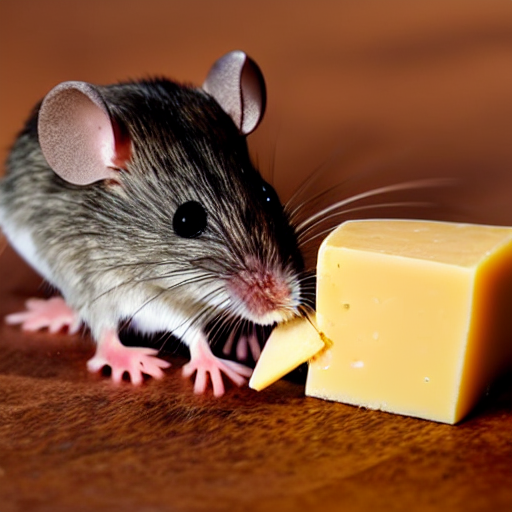

For prompt: A mouse eating cheese
Generated StableDiff image in style: freefonix-style


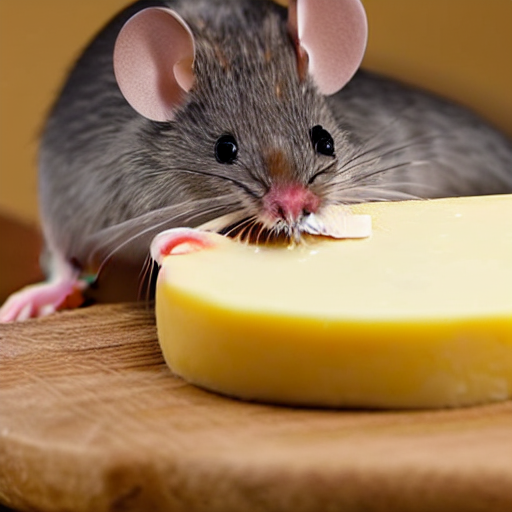

For prompt: A mouse eating cheese
Generated StableDiff image in style: sculptural-style


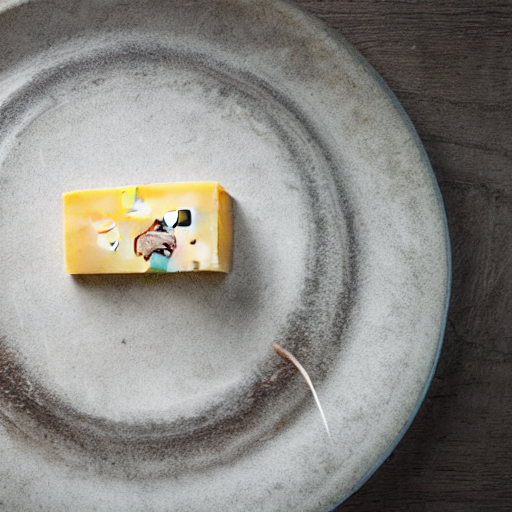

For prompt: A mouse eating cheese
Generated StableDiff image in style: herge-style


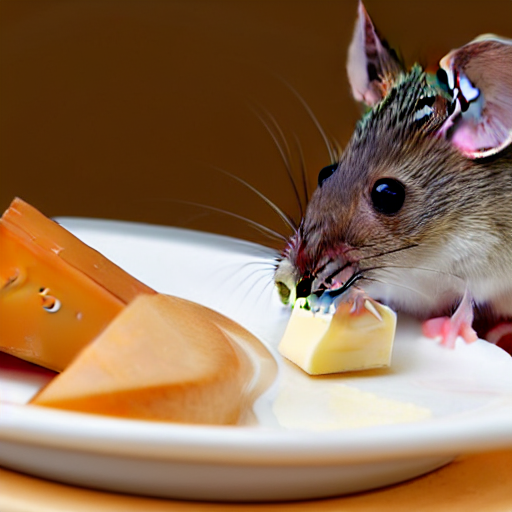

For prompt: A mouse eating cheese
Generated StableDiff image in style: summie-style


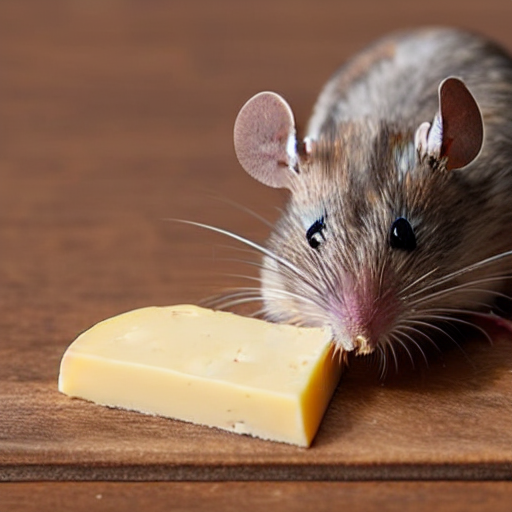

For prompt: A mouse eating cheese
Generated StableDiff image in style: birb-style


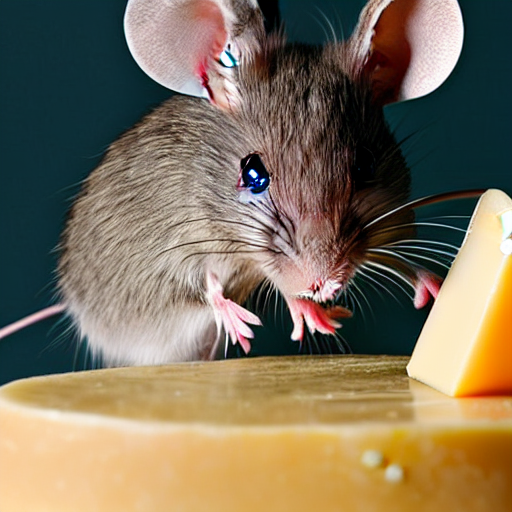

In [42]:
for i in range(len(imgs)):
    img = imgs[i]
    print(f"For prompt: {input_p}")
    print(f"Generated StableDiff image in style: {STYLE_KEYS[i]}")
    display(img)